In [117]:
library(lme4)
library(lmerTest)
library(emmeans)
library(repr)
library(glue)
library(performance)
library(IRdisplay)
library(comprehenr)
library(GLMMadaptive)
library(multilevelTools)
library(data.table)
library(dplyr)
library(ggplot2)
library(ordinal)
library(tibble)
library(tidyr)
library(data.table)
library(xtable)
library(RVAideMemoire)


*** Package RVAideMemoire v 0.9-83-7 ***


Attaching package: 'RVAideMemoire'


The following object is masked from 'package:lme4':

    dummy




In [8]:
options(width = 160, repr.plot.width = 20, repr.plot.height = 8)

In [9]:
current_participants_df <- read.csv('./human_evals_data/current_participants_df.csv')

# Set columns as categorical
current_participants_df$participant_id <- as.factor(current_participants_df$participant_id)
current_participants_df$game_id <- as.factor(current_participants_df$game_id)
current_participants_df$game_type <- as.factor(current_participants_df$game_type)
current_participants_df$full_game_id <- as.factor(current_participants_df$full_game_id)

# Change the order of game_type levels
current_participants_df$game_type <- factor(current_participants_df$game_type, levels = c('unmatched', 'unmatched_top_30', 'matched', 'real'))


# Set columns as booleans
current_participants_df$real <- as.logical(current_participants_df$real)
current_participants_df$matched <- as.logical(current_participants_df$matched)
current_participants_df$model_game <- (!current_participants_df$real)

ATTRIBUTES <- c("confident", "fun_play", "fun_watch", "capability", "goldilocks", "creativity", "human_likeness")
NORMALIZED_ATTRIBUTES <- to_vec(for (attr in ATTRIBUTES) { glue("normalized_{attr}") } )
CENTERED_ATTRIBUTES <- to_vec(for (attr in ATTRIBUTES) { glue("centered_{attr}") } )
FULL_NORMALIZED_ATTRIBUTES <- to_vec(for (attr in ATTRIBUTES) { glue("full_normalized_{attr}") })

for (i in seq_along(CENTERED_ATTRIBUTES)) {
    current_participants_df[[CENTERED_ATTRIBUTES[i]]] <- current_participants_df[[ATTRIBUTES[i]]] - 3
}

for (i in seq_along(FULL_NORMALIZED_ATTRIBUTES)) {
    current_participants_df[[FULL_NORMALIZED_ATTRIBUTES[i]]] <- (current_participants_df[[ATTRIBUTES[i]]] - mean(current_participants_df[[ATTRIBUTES[i]]])) / sd(current_participants_df[[ATTRIBUTES[i]]])
}



print(dim(current_participants_df))
head(current_participants_df, 2)

[1] 1292   48


,participant_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,...,centered_goldilocks,centered_creativity,centered_human_likeness,full_normalized_confident,full_normalized_fun_play,full_normalized_fun_watch,full_normalized_capability,full_normalized_goldilocks,full_normalized_creativity,full_normalized_human_likeness
,<fct>,<fct>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)",FALSE,FALSE,4,3,3,5,3,2,...,0,-1,-1,0.3349299,0.685856,0.736462,1.7028050,0.3154651,-0.1941839,-0.3231405
2,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)",FALSE,FALSE,4,3,3,4,3,3,...,0,0,-1,0.3349299,0.685856,0.736462,0.8894874,0.3154651,0.7489952,-0.3231405


In [10]:
filtered_df <- current_participants_df[current_participants_df$game_type != 'unmatched', ]
filtered_df$game_type <- droplevels(filtered_df$game_type)

print(dim(filtered_df))
head(filtered_df, 2)

[1] 892  48


,participant_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,...,centered_goldilocks,centered_creativity,centered_human_likeness,full_normalized_confident,full_normalized_fun_play,full_normalized_fun_watch,full_normalized_capability,full_normalized_goldilocks,full_normalized_creativity,full_normalized_human_likeness
,<fct>,<fct>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",TRUE,TRUE,4,2,2,5,4,3,...,1,0,-1,0.3349299,-0.2092207,-0.1445648,1.70280498,1.2524326,0.7489952,-0.3231405
4,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",FALSE,TRUE,5,4,4,3,2,2,...,-1,-1,-1,1.1049113,1.5809328,1.6174888,0.07616983,-0.6215025,-0.1941839,-0.3231405


In [11]:
N_POINTS = 50


buildFitnessData <- function() {
    # Get the min and max of the normalized fitness
    fitness.min <- min(filtered_df$normalized_fitness);
    fitness.max <- max(filtered_df$normalized_fitness);
    fitness.seq <- seq(fitness.min, fitness.max, length.out = N_POINTS);
    # Create a data frame with a row for each sequence of fitness values for each game type
    predict_data_df <- expand.grid(normalized_fitness = fitness.seq, game_type = levels(filtered_df$game_type));
    # replicate each row 3 times (once for each percentile)
    predict_data_df <- predict_data_df[rep(row.names(predict_data_df), each = 3),];

    predict_data_df <- predict_data_df %>%
        mutate(percentile = rep(c(20, 50, 80), times = N_POINTS * 3)) %>%
        mutate(percentile = as.factor(percentile));

    return(predict_data_df);
}


extractGameEffects <- function(model) {
    if (missing(model)) {
        model = attr.mm;
    }

    attr.game_effects_df <- ranef(model)$full_game_id;
    colnames(attr.game_effects_df)[1] <- c("effect");
    attr.game_effects_df <- rownames_to_column(attr.game_effects_df, var = "full_game_id");
    attr.game_effects_df$full_game_id <- factor(attr.game_effects_df$full_game_id, levels = levels(filtered_df$full_game_id));

    limited_filtered_df <- filtered_df %>%
        select(full_game_id, game_type) %>%
        distinct();

    attr.game_effects_df <- left_join(attr.game_effects_df, limited_filtered_df, by = "full_game_id");


    percentiles <- attr.game_effects_df %>%
        group_by(game_type) %>%
        summarize(percentile_20 = quantile(effect, 0.20),
                percentile_50 = quantile(effect, 0.50),
                percentile_80 = quantile(effect, 0.80)) %>%
        pivot_longer(cols = starts_with("percentile"),
                    names_to = "percentile",
                    values_to = "game_effect") %>%
        mutate(percentile = gsub("percentile_", "", percentile)) %>%
        mutate(percentile = as.factor(percentile));

    return(percentiles);
}


extractParticipantEffects <- function(model) {
    if (missing(model)) {
        model = attr.mm;
    }

    attr.participant_effects_df <- ranef(model)$participant_id;
    colnames(attr.participant_effects_df)[1] <- c("effect");
    attr.participant_effects_df <- rownames_to_column(attr.participant_effects_df, var = "participant_id");
    attr.participant_effects_df$participant_id <- factor(attr.participant_effects_df$participant_id, levels = levels(filtered_df$participant_id));

    percentiles <- attr.participant_effects_df %>%
        summarize(percentile_20 = quantile(effect, 0.20),
                percentile_50 = quantile(effect, 0.50),
                percentile_80 = quantile(effect, 0.80)) %>%
        pivot_longer(cols = starts_with("percentile"),
                    names_to = "percentile",
                    values_to = "participant_effect") %>%
        mutate(percentile = gsub("percentile_", "", percentile)) %>%
        mutate(percentile = as.factor(percentile)) %>%
        rename(participant_percentile = percentile);

    return(percentiles);
}


extractCoefData <- function(model) {
    if (missing(model)) {
        model = attr.mm;
    }

    attr.coef <- coef(attr.mm);
    fitness_coef <- attr.coef[length(attr.coef)];
    coef.df <- as.data.frame(attr.coef[5:(length(attr.coef) - 1)])
    colnames(coef.df)[1] <- "game_type_intercept";
    row_names <- rownames(coef.df);
    row_names <- gsub("C\\(game_type\\)", "", row_names);
    rownames(coef.df) <- row_names;

    coef.df <- rownames_to_column(coef.df, var = "game_type");
    coef.df <- rbind(coef.df, c(game_type = "unmatched_top_30", game_type_intercept = 0));
    coef.df$game_type <- as.factor(coef.df$game_type);
    coef.df$game_type_intercept <- as.numeric(coef.df$game_type_intercept);

    return(coef.df);
}

plotPredictData <- function(merged_predict_df) {
    participant_titles <- to_vec(for (p in levels(merged_predict_df$participant_percentile)) { glue("{p}th Percentile Participant") } );
    names(participant_titles) <- levels(merged_predict_df$participant_percentile);

    return(print(ggplot(merged_predict_df, aes(x = normalized_fitness, y = bin, color = game_type, linetype = percentile)) +
        facet_wrap(vars(participant_percentile), nrow = 1, labeller = labeller(cyl = participant_titles)) +
        geom_line(size = 1.25) +
        labs(x = "Normalized Fitness", y = attr) +
        scale_color_manual(values = c("unmatched" = "red", "unmatched_top_30" = "blue", "matched" = "green", "real" = "purple")) +
        scale_linetype_manual(values = c("20" = "dashed", "50" = "solid", "80" = "dotted")) +
        theme_minimal() +
        theme(
            plot.margin = margin(2, 2, 2, 2, "cm"),
            text = element_text(size = 16),
            axis.text = element_text(size = 14),
        ) + 
        ggtitle(glue("{attr} by Game Type and Percentile")) 
        ));

    # return(print(ggplot(merged_predict_df, aes(x = normalized_fitness, y = bin, color = game_type, linetype = percentile)) +
    #     geom_line(size = 1.25) +
    #     labs(x = "Normalized Fitness", y = attr) +
    #     scale_color_manual(values = c("unmatched" = "red", "unmatched_top_30" = "blue", "matched" = "green", "real" = "purple")) +
    #     scale_linetype_manual(values = c("20" = "dashed", "50" = "solid", "80" = "dotted")) +
    #     theme_minimal() +
    #     theme(
    #         plot.margin = margin(2, 2, 2, 2, "cm"),
    #         text = element_text(size = 16),
    #         axis.text = element_text(size = 14),
    #     ) + 
    #     ggtitle(glue("{attr} by Game Type and Percentile"))))
}

plotModelPredictions <- function(model) {
    if (missing(model)) {
        model = attr.mm;
    }

    predict_data_df <- buildFitnessData();
    percentiles_df <- extractGameEffects(model);

    predict_data_df <-
        left_join(predict_data_df, percentiles_df, by = c("game_type", "percentile"));
    
    coef_df <- extractCoefData(model);
    attr.coef <- coef(attr.mm);
    fitness_coef <- attr.coef[length(attr.coef)];

    participant_effects_df <- extractParticipantEffects(model);
    predict_data_df <- merge(predict_data_df, participant_effects_df, by = NULL);

    merged_predict_df <- 
        merge(predict_data_df, coef_df, by = "game_type", all.x = TRUE) %>%
        # add the prediction
        mutate(prediction = (merged_predict_df$game_type_intercept + (fitness_coef * merged_predict_df$normalized_fitness) + merged_predict_df$game_effect + merged_predict_df$participant_effect)) %>%
        # bin the prediction
        mutate(bin = cut(prediction, breaks = c(-Inf, attr.coef[1:4], Inf), labels = 1:5, include.lowest = TRUE)) %>%
        mutate(bin = as.double(bin)) %>%
        # Add 0.1 if game type is 'matched' and 0.2 if game type is 'real'
        mutate(bin = ifelse(game_type == 'unmatched_top_30', bin - 0.15, bin)) %>%
        mutate(bin = ifelse(game_type == 'real', bin + 0.15, bin)) %>%
        mutate(bin = ifelse(percentile == 20, bin - 0.05, bin)) %>%
        mutate(bin = ifelse(percentile == 80, bin + 0.05, bin));

    return(plotPredictData(merged_predict_df));
}

## Comparing some models explicitly

In [12]:
## Do we need a mixed effect for the games?

game_id_results_df <- data.frame(
    attribute = character(),
    model = character(),
    aic = numeric(),
    bic = numeric(),
    # aic_diff = numeric(),
    # chisq = numeric(),
    # pvalue = numeric()
)

# Iterate through attributes
for (attr in ATTRIBUTES) {


}    

ERROR: Error in data.frame(attribute = character(), model = character(), aic = numeric(), : argument is missing, with no default


## Do we need a random effect for games?

In [13]:
model_comparison_df <- data.frame(
    model = character(),
    attribute = character(),
    aic = numeric(),
    aic_rank = numeric(),
    bic = numeric(),
    bic_rank = numeric()
);


CANDIDATE_MODELS = c(
    game_type_no_game_effect = "C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id)",
    game_type_game_effect = "C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id) + (1 | full_game_id)",
    game_type_game_effect_no_participant_effect = "C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | full_game_id)",
    archive_distance_no_game_effect = "C({attr}) ~ 1 + normalized_archive_distance + normalized_fitness + (1 | participant_id)",
    archive_distance_game_effect = "C({attr}) ~ 1 + normalized_archive_distance + normalized_fitness + (1 | participant_id) + (1 | full_game_id)",
    archive_distance_game_effect_no_participant_effect = "C({attr}) ~ 1 + normalized_archive_distance + normalized_fitness + (1 | full_game_id)",
    archive_distance_model_game_no_game_effect = "C({attr}) ~ 1 + normalized_archive_distance + normalized_fitness + model_game + (1 | participant_id)",
    archive_distance_model_game_game_effect = "C({attr}) ~ 1 + normalized_archive_distance + normalized_fitness + model_game + (1 | participant_id) + (1 | full_game_id)"
);

for (attr in ATTRIBUTES) {
    attribute_df <- data.frame(
        model = character(),
        aic = numeric(),
        aic_rank = numeric(),
        bic = numeric(),
        bic_rank = numeric()
    );

    # iterate through the candidate models
    for (model_name in names(CANDIDATE_MODELS)) {
        model_formula <- CANDIDATE_MODELS[[model_name]];
        model <- clmm(as.formula(glue(model_formula)), data = filtered_df);
        aic <- AIC(model);
        bic <- BIC(model);
        
        attribute_df <- rbind(attribute_df, data.frame(
            model = model_name,
            aic = aic,
            aic_rank = NA,
            bic = bic,
            bic_rank = NA
        ));
    }

    # rank the models
    attribute_df$aic_rank <- rank(attribute_df$aic);    
    attribute_df$bic_rank <- rank(attribute_df$bic);
    attribute_df$attribute <- attr;

    model_comparison_df <- rbind(model_comparison_df, attribute_df);
}

head(model_comparison_df)

,model,aic,aic_rank,bic,bic_rank,attribute
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,game_type_no_game_effect,2431.622,5,2469.970,5,confident
2,game_type_game_effect,2382.587,2,2425.728,3,confident
3,game_type_game_effect_no_participant_effect,2481.368,7,2519.715,8,confident
4,archive_distance_no_game_effect,2441.334,6,2474.888,6,confident
5,archive_distance_game_effect,2385.506,3,2423.854,1,confident
6,archive_distance_game_effect_no_participant_effect,2485.772,8,2519.327,7,confident


In [14]:
# group by model and compute means
model_comparison_summary_df <- model_comparison_df %>%
    group_by(model) %>%
    summarize(
        mean_aic = mean(aic),
        mean_aic_rank = mean(aic_rank),
        mean_bic = mean(bic),
        mean_bic_rank = mean(bic_rank)
    ) %>%
    arrange(mean_bic_rank);

model_comparison_summary_df

model,mean_aic,mean_aic_rank,mean_bic,mean_bic_rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
archive_distance_game_effect,2301.782,2.714286,2340.129,1.714286
game_type_game_effect,2299.193,1.571429,2342.335,2.571429
archive_distance_model_game_game_effect,2300.796,2.714286,2343.938,3.000000
game_type_no_game_effect,2342.645,4.285714,2380.993,4.428571
archive_distance_no_game_effect,2351.116,5.571429,2384.670,5.000000
archive_distance_model_game_no_game_effect,2345.565,5.000000,2383.913,5.142857
archive_distance_game_effect_no_participant_effect,2531.014,7.428571,2564.568,6.714286
game_type_game_effect_no_participant_effect,2529.042,6.714286,2567.389,7.428571


In [15]:
model_comparison_summary_df <- model_comparison_df %>%
    group_by(model) %>%
    summarize(
        mean_aic = mean(aic),
        mean_aic_rank = mean(aic_rank),
        mean_bic = mean(bic),
        mean_bic_rank = mean(bic_rank)
    ) %>%
    arrange(mean_aic_rank);

model_comparison_summary_df

model,mean_aic,mean_aic_rank,mean_bic,mean_bic_rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
game_type_game_effect,2299.193,1.571429,2342.335,2.571429
archive_distance_game_effect,2301.782,2.714286,2340.129,1.714286
archive_distance_model_game_game_effect,2300.796,2.714286,2343.938,3.000000
game_type_no_game_effect,2342.645,4.285714,2380.993,4.428571
archive_distance_model_game_no_game_effect,2345.565,5.000000,2383.913,5.142857
archive_distance_no_game_effect,2351.116,5.571429,2384.670,5.000000
game_type_game_effect_no_participant_effect,2529.042,6.714286,2567.389,7.428571
archive_distance_game_effect_no_participant_effect,2531.014,7.428571,2564.568,6.714286


In [16]:


# Iterate through attributes
for (attr in ATTRIBUTES) {
    attr.mm_no_game_id <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id)")),
        data = filtered_df, Hess = TRUE
    )
    attr.mm_with_game_id <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id) + (1 | full_game_id)")),
        data = filtered_df, Hess = TRUE
    )

    anova_results <- anova(attr.mm_no_game_id, attr.mm_with_game_id)
    attr.aic_before <- anova_results$AIC[[1]]
    attr.aic_after <- anova_results$AIC[[2]]
    attr.aic_diff <- attr.aic_before - attr.aic_after
    attr.chisq <- anova_results$Chisq[[2]]
    attr.pvalue <- anova_results$`Pr(>Chisq)`[[2]] 
    
    print(glue("For {attr}, adding the game ID random effects results in AIC diff: {format(attr.aic_diff, nsmall=3)} | Chi-squared: {format(attr.chisq, nsmall=3)} | p-value: {format(attr.pvalue, nsmall=3)}"))
}



For confident, adding the game ID random effects results in AIC diff: 49.03556 | Chi-squared: NULL | p-value: 9.070776e-13
For fun_play, adding the game ID random effects results in AIC diff: 39.63944 | Chi-squared: NULL | p-value: 1.097565e-10
For fun_watch, adding the game ID random effects results in AIC diff: 26.17496 | Chi-squared: NULL | p-value: 1.108294e-07
For capability, adding the game ID random effects results in AIC diff: -1.977122 | Chi-squared: NULL | p-value: 0.8797742
For goldilocks, adding the game ID random effects results in AIC diff: 108.3868 | Chi-squared: NULL | p-value: 8.062017e-26
For creativity, adding the game ID random effects results in AIC diff: 53.75391 | Chi-squared: NULL | p-value: 8.213478e-14
For human_likeness, adding the game ID random effects results in AIC diff: 29.1491 | Chi-squared: NULL | p-value: 2.389503e-08


Conclusion: we absolutely also need a mixed effect for the games

## Does a model with archive distances fit better than a model with game type categories?

In [17]:
# Iterate through attributes
for (attr in ATTRIBUTES) {
    # Create formula with current attribute
    # attr.lmer_no_game_id <- lmer(formula = as.formula(glue("{attr} ~ 1 + game_type + normalized_fitness + (1 | participant_id)")), data = filtered_df)
    # attr.lmer_with_game_id <- update(attr.lmer_no_game_id, . ~ . + (1 + game_type | full_game_id))

    attr.game_type <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id) + (1 | full_game_id)")),
        data = filtered_df, Hess = TRUE
    )
    attr.archive_distance <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + normalized_archive_distance + normalized_fitness + (1 | participant_id) + (1 | full_game_id)")),
        data = filtered_df, Hess = TRUE
    )

    anova_results <- anova(attr.game_type, attr.archive_distance)
    print(anova_results)
    attr.aic_diff <- anova_results$AIC[[1]] - anova_results$AIC[[2]]
    attr.chisq <- anova_results$Chisq[[2]]
    attr.pvalue <- anova_results$`Pr(>Chisq)`[[2]] 
    # fixed_effects_aic <- AIC(logLik(attr.glm))
    # mixed_effects_aic <- AIC(logLik(attr.lmer))
    # aic_diff <- fixed_effects_aic - mixed_effects_aic
    print(glue("For {attr}, switching game type for archive distance results in AIC diff: {format(attr.aic_diff, nsmall=3)} | Chi-squared: {format(attr.chisq, nsmall=3)} | p-value: {format(attr.pvalue, nsmall=3)}"))
}

# anova(conf.model.without, conf.model.with)
# summary(confident_model)

Likelihood ratio tests of cumulative link models:
 
                      formula:                                                                                                                         link:
attr.archive_distance as.formula(glue("C({attr}) ~ 1 + normalized_archive_distance + normalized_fitness + (1 | participant_id) + (1 | full_game_id)")) logit
attr.game_type        as.formula(glue("C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id) + (1 | full_game_id)"))                logit
                      threshold:
attr.archive_distance flexible  
attr.game_type        flexible  

                      no.par    AIC  logLik LR.stat df Pr(>Chisq)  
attr.archive_distance      8 2385.5 -1184.8                        
attr.game_type             9 2382.6 -1182.3  4.9194  1    0.02656 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
For confident, switching game type for archive distance results in AIC diff: 2.91938 | Chi-squared: NULL |

Almost exactly the same

## Does adding a model game indicator help further?

In [18]:
# Iterate through attributes
for (attr in ATTRIBUTES) {
    # Create formula with current attribute
    # attr.lmer_no_game_id <- lmer(formula = as.formula(glue("{attr} ~ 1 + game_type + normalized_fitness + (1 | participant_id)")), data = filtered_df)
    # attr.lmer_with_game_id <- update(attr.lmer_no_game_id, . ~ . + (1 + game_type | full_game_id))

    attr.no_model_game <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + normalized_archive_distance + normalized_fitness + (1 | participant_id) + (1 | full_game_id)")),
        data = filtered_df, Hess = TRUE
    )
    attr.model_game <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + normalized_archive_distance + model_game + normalized_fitness + (1 | participant_id) + (1 | full_game_id)")),
        data = filtered_df, Hess = TRUE
    )
    # attr.model_game <- clmm(
    #     formula = as.formula(glue("C({attr}) ~ 1 + normalized_archive_distance + normalized_fitness + (1 | participant_id) + (1 | full_game_id)")),
    #     data = filtered_df, Hess = TRUE
    # )

    anova_results <- anova(attr.no_model_game, attr.model_game)
    attr.aic_diff <- anova_results$AIC[[1]] - anova_results$AIC[[2]]
    attr.chisq <- anova_results$Chisq[[2]]
    attr.pvalue <- anova_results$`Pr(>Chisq)`[[2]] 
    # fixed_effects_aic <- AIC(logLik(attr.glm))
    # mixed_effects_aic <- AIC(logLik(attr.lmer))
    # aic_diff <- fixed_effects_aic - mixed_effects_aic
    print(glue("For {attr}, adding a model game indicator results in AIC diff: {format(attr.aic_diff, nsmall=3)} | Chi-squared: {format(attr.chisq, nsmall=3)} | p-value: {format(attr.pvalue, nsmall=3)}"))
}

# anova(conf.model.without, conf.model.with)
# summary(confident_model)

For confident, adding a model game indicator results in AIC diff: 3.228613 | Chi-squared: NULL | p-value: 0.02221824
For fun_play, adding a model game indicator results in AIC diff: 2.091675 | Chi-squared: NULL | p-value: 0.0430949
For fun_watch, adding a model game indicator results in AIC diff: -0.6352981 | Chi-squared: NULL | p-value: 0.2427243
For capability, adding a model game indicator results in AIC diff: -1.615036 | Chi-squared: NULL | p-value: 0.5349583
For goldilocks, adding a model game indicator results in AIC diff: -0.5241679 | Chi-squared: NULL | p-value: 0.2244278
For creativity, adding a model game indicator results in AIC diff: -1.880096 | Chi-squared: NULL | p-value: 0.7291388
For human_likeness, adding a model game indicator results in AIC diff: 6.231471 | Chi-squared: NULL | p-value: 0.004117014


Not really.

## Let's analyze these now

In [19]:
analysis_df <- data.table::copy(filtered_df)
# analysis_df$game_type <- factor(analysis_df$game_type, levels = c('real', 'matched', 'unmatched', 'unmatched_top_30'))
# analysis_df <- filtered_df[filtered_df$game_type != 'unmatched_top_30', ]
# analysis_df$game_type <- droplevels(analysis_df$game_type)
model_list <- list()

for (attr in ATTRIBUTES) {
    display_markdown(glue("## {attr}"))

    # Create formula with current attribute
    # attr.lmer <- lmer(formula = as.formula(glue("{attr} ~ 1 + game_type + normalized_fitness + (1 | participant_id) + (game_type | full_game_id)")), data = filtered_df)

    attr.mm <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1  + normalized_fitness + C(game_type) + (1 | participant_id) + (1 | full_game_id)")),
        data = analysis_df, Hess = TRUE
    )

    model_list[[attr]] <- attr.mm

    display_markdown("### Mixed Effects Model")    
    display(summary(attr.mm))

    attr.marginal_means = emmeans(attr.mm, "game_type")
    display_markdown("### Marginal Means")
    display(pairs(attr.marginal_means, reverse = TRUE))

    # plotModelPredictions(attr.mm);
    # ggplot()

    display_markdown("------------------")
}


## confident

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(confident) ~ 1 + normalized_fitness + C(game_type) + (1 | participant_id) +      (1 | full_game_id)
data:    analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1182.29 2382.59 755(3012) 2.29e-04 8.8e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.2831   1.1327  
 full_game_id   (Intercept) 0.7669   0.8757  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
normalized_fitness    0.8459     0.1504   5.625 1.86e-08 ***
C(game_type)matched   0.5253     0.2974   1.766   0.0773 .  
C(game_type)real      1.1511     0.2852   4.036 5.43e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2 -2.80972    0.26835 -10.471
2|3 -1.36745    0.24135  -5.666
3|4 -0.01

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.525 0.297 Inf   1.766  0.1810
 real - unmatched_top_30       1.151 0.285 Inf   4.036  0.0002
 real - matched                0.626 0.305 Inf   2.055  0.0995

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## fun_play

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(fun_play) ~ 1 + normalized_fitness + C(game_type) + (1 | participant_id) +      (1 | full_game_id)
data:    analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1134.46 2286.92 699(4357) 3.32e-04 6.8e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 2.8697   1.6940  
 full_game_id   (Intercept) 0.5779   0.7602  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
normalized_fitness    0.3956     0.1347   2.936  0.00332 ** 
C(game_type)matched   0.6287     0.2736   2.298  0.02158 *  
C(game_type)real      1.0589     0.2633   4.021  5.8e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -0.9559     0.2597  -3.681
2|3   1.1138     0.2624   4.245
3|4   3.29

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.629 0.274 Inf   2.298  0.0561
 real - unmatched_top_30       1.059 0.263 Inf   4.021  0.0002
 real - matched                0.430 0.273 Inf   1.577  0.2556

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## fun_watch

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(fun_watch) ~ 1 + normalized_fitness + C(game_type) + (1 | participant_id) +      (1 | full_game_id)
data:    analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1077.05 2172.09 642(4301) 3.19e-04 6.8e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 4.4133   2.1008  
 full_game_id   (Intercept) 0.5064   0.7116  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
normalized_fitness    0.1912     0.1302   1.469  0.14196    
C(game_type)matched   0.6413     0.2657   2.414  0.01577 *  
C(game_type)real      0.9118     0.2571   3.547  0.00039 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -0.7974     0.2862  -2.786
2|3   1.4145     0.2925   4.836
3|4   3.5

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.641 0.266 Inf   2.414  0.0417
 real - unmatched_top_30       0.912 0.257 Inf   3.547  0.0011
 real - matched                0.271 0.264 Inf   1.025  0.5608

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## capability

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(capability) ~ 1 + normalized_fitness + C(game_type) + (1 |      participant_id) + (1 | full_game_id)
data:    analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1191.32 2400.65 688(4093) 1.16e-03 4.9e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 3.616428 1.90169 
 full_game_id   (Intercept) 0.007948 0.08915 
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)  
normalized_fitness  -0.18855    0.08718  -2.163   0.0306 *
C(game_type)matched  0.34903    0.17045   2.048   0.0406 *
C(game_type)real     0.23183    0.16090   1.441   0.1496  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -2.9044     0.2543 -11.421
2|3  -0.6740     0.2313  -2.914
3|4   1.1571    

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.349 0.170 Inf   2.048  0.1010
 real - unmatched_top_30       0.232 0.161 Inf   1.441  0.3199
 real - matched               -0.117 0.167 Inf  -0.701  0.7630

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## goldilocks

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(goldilocks) ~ 1 + normalized_fitness + C(game_type) + (1 |      participant_id) + (1 | full_game_id)
data:    analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1106.95 2231.91 570(2858) 1.15e-03 8.2e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.161    1.078   
 full_game_id   (Intercept) 1.256    1.121   
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
normalized_fitness   -0.5878     0.1707  -3.443 0.000576 ***
C(game_type)matched   0.3630     0.3529   1.029 0.303615    
C(game_type)real     -0.2498     0.3377  -0.740 0.459502    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -2.3600     0.2832  -8.335
2|3  -0.7327     0.2700  -2.713
3|4   2.

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.363 0.353 Inf   1.029  0.5587
 real - unmatched_top_30      -0.250 0.338 Inf  -0.740  0.7399
 real - matched               -0.613 0.355 Inf  -1.725  0.1957

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## creativity

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(creativity) ~ 1 + normalized_fitness + C(game_type) + (1 |      participant_id) + (1 | full_game_id)
data:    analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1076.82 2171.64 648(3603) 5.40e-04 7.1e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 2.9318   1.7122  
 full_game_id   (Intercept) 0.8534   0.9238  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)   
normalized_fitness   -0.4863     0.1524  -3.191  0.00142 **
C(game_type)matched   0.5507     0.3101   1.776  0.07580 . 
C(game_type)real      0.4377     0.2983   1.467  0.14226   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -1.2302     0.2820  -4.363
2|3   1.0634     0.2822   3.769
3|4   3.3883

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.551 0.310 Inf   1.776  0.1778
 real - unmatched_top_30       0.438 0.298 Inf   1.467  0.3067
 real - matched               -0.113 0.310 Inf  -0.364  0.9296

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## human_likeness

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(human_likeness) ~ 1 + normalized_fitness + C(game_type) + (1 |      participant_id) + (1 | full_game_id)
data:    analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1215.28 2448.56 661(3291) 1.89e-03 7.5e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.951    1.3967  
 full_game_id   (Intercept) 0.544    0.7375  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
normalized_fitness    0.5698     0.1320   4.316 1.59e-05 ***
C(game_type)matched   0.8368     0.2676   3.128  0.00176 ** 
C(game_type)real      1.4455     0.2583   5.597 2.18e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -0.8014     0.2376  -3.373
2|3   0.9950     0.2399   4.148
3|4 

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.837 0.268 Inf   3.128  0.0050
 real - unmatched_top_30       1.446 0.258 Inf   5.597  <.0001
 real - matched                0.609 0.265 Inf   2.299  0.0559

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

In [76]:
results_table <- data.frame(
    attribute = character(),
    aic = numeric(),
    fit_est = numeric(),
    fit_z = numeric(),
    fit_p = numeric(),
    matched_est = numeric(),
    matched_z = numeric(),
    matched_p = numeric(),
    real_est = numeric(),
    real_z = numeric(),
    real_p = numeric()
)


for (name in names(model_list)) {
    model <- model_list[[name]]
    s <- summary(model)
    table_row <- data.frame(
        attribute = name,
        fit_est = s$coefficients[5, 1],
        fit_z = s$coefficients[5, 3],
        fit_p = s$coefficients[5, 4],
        matched_est = s$coefficients[6, 1],
        matched_z = s$coefficients[6, 3],
        matched_p = s$coefficients[6, 4],
        real_est = s$coefficients[7, 1],
        real_z = s$coefficients[7, 3],
        real_p = s$coefficients[7, 4]
    )
    results_table <- rbind(results_table, table_row)
}



# Iterate through the columns
for (col in c("fit_p", "matched_p", "real_p")) {
    # Iterate through the cells
    for (i in seq_len(nrow(results_table))) {
        # Get the current value
        value <- as.double(results_table[i, col])
        
        # Modify the value based on the conditions
        if (value < 10^-5) {
            print(glue("{col}, {i}, {value}, 1e-5, "))
            results_table[i, col] <- "$P < \\num{1e-5}^{ *** }$"
        } else if (value < 10^-3) {
            print(glue("{col}, {i}, {value}, 1e-3"))
            results_table[i, col] <- "$P < \\num{1e-3}^{ *** }$"
        } else {
            print(glue("{col}, {i}, {value}, neither"))
            v <- format(value, digits = 3, scientific = FALSE)
            stars <- ifelse(value < 0.01, "**", ifelse(value < 0.05, "*", ""))
            if (stars != "") {
                results_table[i, col] <- glue("$P = {v}^{{ {stars} }}$")
            } else {
                results_table[i, col] <- glue("$P = {v}$")
            }
        }
    }
}


results_table

fit_p, 1, 1.85780228530922e-08, 1e-5, 
fit_p, 2, 0.0033219048093993, neither
fit_p, 3, 0.141956799969315, neither
fit_p, 4, 0.0305670535911653, neither
fit_p, 5, 0.000576317586797644, 1e-3
fit_p, 6, 0.00141634048907872, neither
fit_p, 7, 1.58882849621018e-05, 1e-3
matched_p, 1, 0.0773422538445975, neither
matched_p, 2, 0.0215813875428281, neither
matched_p, 3, 0.0157738636438563, neither
matched_p, 4, 0.0405917569018296, neither
matched_p, 5, 0.303614512441827, neither
matched_p, 6, 0.0757965447416219, neither
matched_p, 7, 0.00176235327105234, neither
real_p, 1, 5.43073357891209e-05, 1e-3
real_p, 2, 5.7970184101091e-05, 1e-3
real_p, 3, 0.000390057499242047, 1e-3
real_p, 4, 0.149627812672313, neither
real_p, 5, 0.459501956856266, neither
real_p, 6, 0.142259210083196, neither
real_p, 7, 2.17908797508669e-08, 1e-5, 


attribute,fit_est,fit_z,fit_p,matched_est,matched_z,matched_p,real_est,real_z,real_p
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
confident,0.8458861,5.624747,$P < \num{1e-5}^{ *** }$,0.5253317,1.766320,$P = 0.0773$,1.1511036,4.0362716,$P < \num{1e-3}^{ *** }$
fun_play,0.3956470,2.936265,$P = 0.00332^{ ** }$,0.6287354,2.297656,$P = 0.0216^{ * }$,1.0588619,4.0209245,$P < \num{1e-3}^{ *** }$
fun_watch,0.1912144,1.468543,$P = 0.142$,0.6413077,2.414106,$P = 0.0158^{ * }$,0.9118317,3.5467210,$P < \num{1e-3}^{ *** }$
capability,-0.1885518,-2.162664,$P = 0.0306^{ * }$,0.3490262,2.047676,$P = 0.0406^{ * }$,0.2318314,1.4408474,$P = 0.15$
goldilocks,-0.5877681,-3.442522,$P < \num{1e-3}^{ *** }$,0.3630300,1.028713,$P = 0.304$,-0.2497910,-0.7396672,$P = 0.46$
creativity,-0.4863119,-3.191300,$P = 0.00142^{ ** }$,0.5507002,1.775614,$P = 0.0758$,0.4377153,1.4674297,$P = 0.142$
human_likeness,0.5697904,4.315999,$P < \num{1e-3}^{ *** }$,0.8368069,3.127608,$P = 0.00176^{ ** }$,1.4455453,5.5971463,$P < \num{1e-5}^{ *** }$


In [75]:

# Convert the dataframe to an xtable object
table_latex <- xtable(results_table, digits = 3)

# Print the LaTeX table
print(table_latex, include.rownames = FALSE, floating = FALSE, sanitize.text.function = identity, digits=3)


% latex table generated in R 4.3.2 by xtable 1.8-4 package
% Mon Mar  4 20:47:32 2024
\begin{tabular}{lrrrlrrlrrl}
  \hline
attribute & aic & fit_est & fit_z & fit_p & matched_est & matched_z & matched_p & real_est & real_z & real_p \\ 
  \hline
confident & 2382.587 & 0.846 & 5.625 & $P < \num{1e-5}^{ *** }$ & 0.525 & 1.766 & $P = 0.0773$ & 1.151 & 4.036 & $P < \num{1e-3}^{ *** }$ \\ 
  fun_play & 2286.921 & 0.396 & 2.936 & $P = 0.00332^**$ & 0.629 & 2.298 & $P = 0.0216^*$ & 1.059 & 4.021 & $P < \num{1e-3}^{ *** }$ \\ 
  fun_watch & 2172.090 & 0.191 & 1.469 & $P = 0.142$ & 0.641 & 2.414 & $P = 0.0158^*$ & 0.912 & 3.547 & $P < \num{1e-3}^{ *** }$ \\ 
  capability & 2400.648 & -0.189 & -2.163 & $P = 0.0306^*$ & 0.349 & 2.048 & $P = 0.0406^*$ & 0.232 & 1.441 & $P = 0.15$ \\ 
  goldilocks & 2231.909 & -0.588 & -3.443 & $P < \num{1e-3}^{ *** }$ & 0.363 & 1.029 & $P = 0.304$ & -0.250 & -0.740 & $P = 0.46$ \\ 
  creativity & 2171.641 & -0.486 & -3.191 & $P = 0.00142^**$ & 0.551 & 1.776 & $P =

In [148]:
em <- emmeans(model_list$confident, "game_type")
p <- pairs(em, reverse = TRUE)
s <- summary(p)
s


Warning message:
"contrasts dropped from factor C(game_type)"


,contrast,estimate,SE,df,z.ratio,p.value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,matched - unmatched_top_30,0.5253317,0.2974160,Inf,1.766320,0.1810123898
2,real - unmatched_top_30,1.1511036,0.2851898,Inf,4.036272,0.0001605517
3,real - matched,0.6257718,0.3045627,Inf,2.054657,0.0994748132


In [154]:
mm_results_table <- data.frame(
    attribute = character(),
    r_m_est = numeric(),
    r_m_z = numeric(),
    r_m_p = numeric(),
    r_u_est = numeric(),
    r_u_z = numeric(),
    r_u_p = numeric(),
    m_u_est = numeric(),
    m_u_z = numeric(),
    m_u_p = numeric()
    
)


for (name in names(model_list)) {
    model <- model_list[[name]]
    em <- emmeans(model, "game_type")
    p <- pairs(em, reverse = TRUE)
    s <- summary(p)
    table_row <- data.frame(
        attribute = name,
        r_m_est = s[3, 2],
        r_m_z = s[3, 5],
        r_m_p = s[3, 6],
        r_u_est = s[2, 2],
        r_u_z = s[2, 5],
        r_u_p = s[2, 6],
        m_u_est = s[1, 2],
        m_u_z = s[1, 5],
        m_u_p = s[1, 6]
    )
    mm_results_table <- rbind(mm_results_table, table_row)
}


# Iterate through the columns
for (col in c("m_u_p", "r_u_p", "r_m_p")) {
    # Iterate through the cells
    for (i in seq_len(nrow(mm_results_table))) {
        # Get the current value
        value <- as.double(mm_results_table[i, col])

        # Modify the value based on the conditions
        if (value < 10^-5) {
            print(glue("{col}, {i}, {value}, 1e-5, "))
            mm_results_table[i, col] <- "$P < \\num{1e-5}^{ *** }$"
        } else if (value < 10^-3) {
            print(glue("{col}, {i}, {value}, 1e-3"))
            mm_results_table[i, col] <- "$P < \\num{1e-3}^{ *** }$"
        } else {
            print(glue("{col}, {i}, {value}, neither"))
            v <- format(value, digits = 3, scientific = FALSE)
            stars <- ifelse(value < 0.01, "**", ifelse(value < 0.05, "*", ""))
            if (stars != "") {
                mm_results_table[i, col] <- glue("$P = {v}^{{ {stars} }}$")
            } else {
                mm_results_table[i, col] <- glue("$P = {v}$")
            }
        }
    }
}


# Convert the dataframe to an xtable object
table_latex <- xtable(mm_results_table, digits = 3)

# Print the LaTeX table
print(table_latex, include.rownames = FALSE, floating = FALSE, sanitize.text.function = identity, digits=3)



Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"


m_u_p, 1, 0.181012389789048, neither
m_u_p, 2, 0.0561173428284542, neither
m_u_p, 3, 0.0417322801443991, neither
m_u_p, 4, 0.101031830223043, neither
m_u_p, 5, 0.558692214891852, neither
m_u_p, 6, 0.177796836141712, neither
m_u_p, 7, 0.00501333753296163, neither
r_u_p, 1, 0.000160551650450702, 1e-3
r_u_p, 2, 0.000171320137927755, 1e-3
r_u_p, 3, 0.0011353811156023, neither
r_u_p, 4, 0.319917888879621, neither
r_u_p, 5, 0.739863313557509, neither
r_u_p, 6, 0.306680812492611, neither
r_u_p, 7, 6.53130137751035e-08, 1e-5, 
r_m_p, 1, 0.0994748132237283, neither
r_m_p, 2, 0.255577580892457, neither
r_m_p, 3, 0.560796988673304, neither
r_m_p, 4, 0.76302008268496, neither
r_m_p, 5, 0.195731856487346, neither
r_m_p, 6, 0.929609083784071, neither
r_m_p, 7, 0.0558645245395131, neither
% latex table generated in R 4.3.2 by xtable 1.8-4 package
% Tue Mar  5 14:40:29 2024
\begin{tabular}{lrrlrrlrrl}
  \hline
attribute & r_m_est & r_m_z & r_m_p & r_u_est & r_u_z & r_u_p & m_u_est & m_u_z & m_u_p \\ 


In [35]:
s$coefficients

,Estimate,Std. Error,z value,Pr(>|z|)
1|2,-2.80971788,0.2683452,-10.47053592,1.179732e-25
2|3,-1.36745124,0.2413453,-5.66595450,1.462083e-08
3|4,-0.01259314,0.2353181,-0.05351539,9.573213e-01
4|5,1.58470281,0.2423721,6.53830513,6.221989e-11
normalized_fitness,0.84588610,0.1503865,5.62474684,1.857802e-08
C(game_type)matched,0.52533175,0.2974160,1.76631955,7.734225e-02
C(game_type)real,1.15110358,0.2851898,4.03627164,5.430734e-05


In [36]:
s$coefficients[5, 1]

[1] 0.8458861

Warning message:
"contrasts dropped from factor C(game_type)"


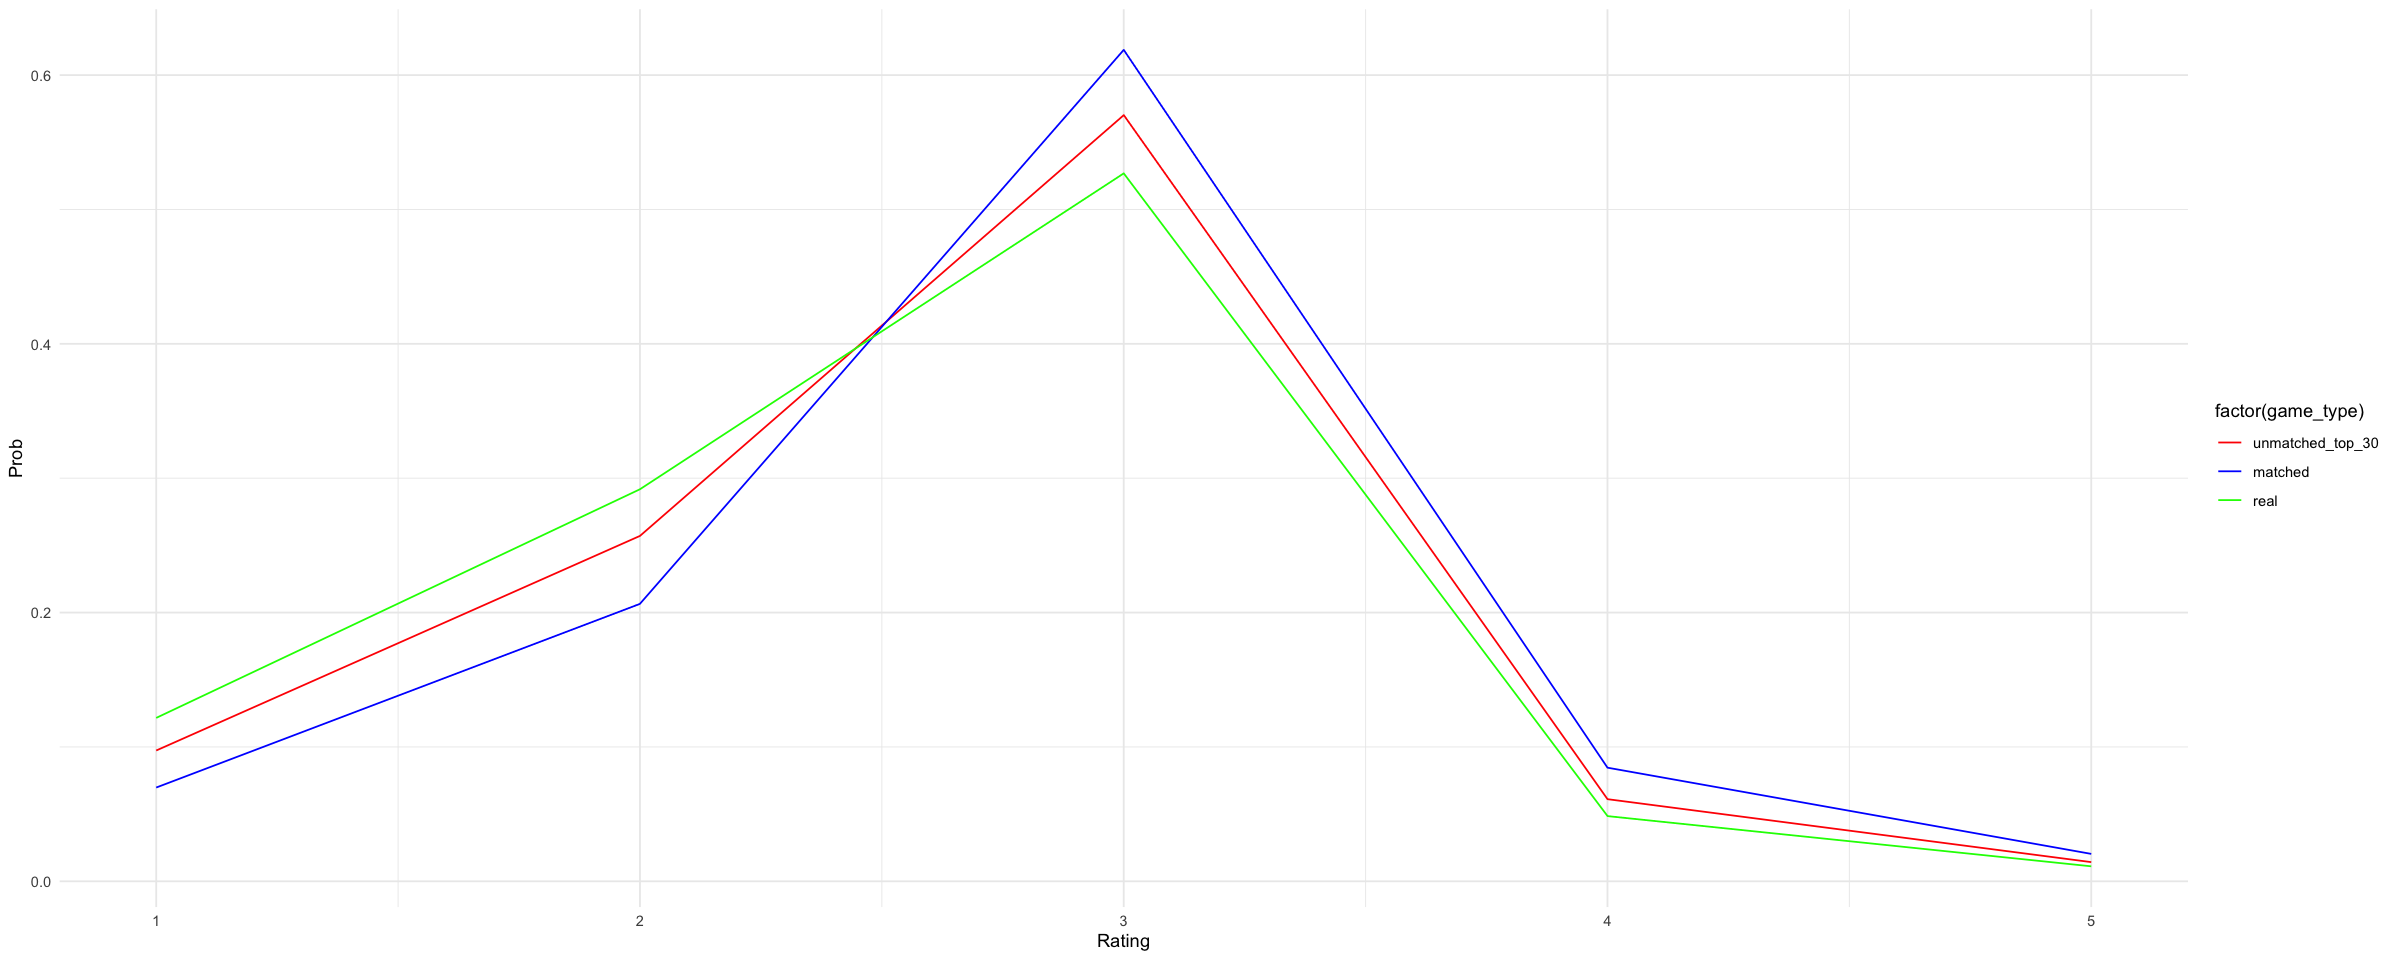

In [137]:
emm <- emmeans(model_list$goldilocks, ~ game_type | cut, mode = "linear.predictor")
mp <- rating.emmeans(emm)

mp$Rating <- as.numeric(mp$Rating)

ggplot(mp, aes(x = Rating, y = Prob, color = factor(game_type))) +
    geom_line() +
    labs(x = "Rating", y = "Prob") +
    scale_color_manual(values = c("red", "blue", "green")) +
    theme_minimal()

In [ ]:
fake.predict.clmm <- function(model, newdata) {
  # Actual prediction function
  pred <- function(eta, theta, cat = 1:(length(theta) + 1), inv.link = plogis) {
    Theta <- c(-1000, theta, 1000)
    sapply(cat, function(j) inv.link(Theta[j + 1] - eta) - inv.link(Theta[j] - eta))
  }
  
  # Multiply each row by the coefficients
  coefs <- c(model$beta, unlist(model$ST))
  print(coefs);
  xbetas <- sweep(newdata, MARGIN = 2, coefs, `*`)
  
#   # Make predictions
#   pred.mat <- data.frame(pred(eta=rowSums(xbetas), theta=model$Theta))
#   colnames(pred.mat) <- levels(model$model[,1])
#   pred.mat

    
}

fake.predict.clmm(attr.mm, filtered_df)

normalized_archive_distance              model_gameTRUE          normalized_fitness              participant_id                full_game_id 
                 -0.3625887                  -0.7622560                   0.5774844                   1.4010910                   0.7678539 


Warning message in sweep(newdata, MARGIN = 2, coefs, `*`):
"STATS does not recycle exactly across MARGIN"
Warning message in Ops.factor(left, right):
"'*' not meaningful for factors"
Warning message in Ops.factor(left, right):
"'*' not meaningful for factors"


ERROR: Error in FUN(left, right): non-numeric argument to binary operator


In [ ]:
help(sweep)

sweep                   package:base                   R Documentation

_S_w_e_e_p _o_u_t _A_r_r_a_y _S_u_m_m_a_r_i_e_s

_D_e_s_c_r_i_p_t_i_o_n:

     Return an array obtained from an input array by sweeping out a
     summary statistic.

_U_s_a_g_e:

     sweep(x, MARGIN, STATS, FUN = "-", check.margin = TRUE, ...)
     
_A_r_g_u_m_e_n_t_s:

       x: an array, including a matrix.

  MARGIN: a vector of indices giving the extent(s) of 'x' which
          correspond to 'STATS'.  Where 'x' has named dimnames, it can
          be a character vector selecting dimension names.

   STATS: the summary statistic which is to be swept out.

     FUN: the function to be used to carry out the sweep.

check.margin: logical.  If 'TRUE' (the default), warn if the length or
          dimensions of 'STATS' do not match the specified dimensions
          of 'x'.  Set to 'FALSE' for a small speed gain when you
          _know_ that dimensions match.

     .

In [ ]:
N_POINTS = 50

fitness.min <- min(filtered_df$normalized_fitness)
fitness.max <- max(filtered_df$normalized_fitness)

# Generate a sequence of numbers from 0 to 1 with 10 equally spaced points
fitness.seq <- seq(fitness.min, fitness.max, length.out = N_POINTS)

# Create a data frame with a row for each sequence of fitness values for each game type
predict_data_df <- expand.grid(normalized_fitness = fitness.seq, game_type = levels(filtered_df$game_type))

# replicate each row 3 times (once for each percentile)
predict_data_df <- predict_data_df[rep(row.names(predict_data_df), each = 3),]


predict_data_df <- predict_data_df %>%
    mutate(percentile = rep(c(20, 50, 80), times = N_POINTS * 3)) %>%
    mutate(percentile = as.factor(percentile))

head(predict_data_df)





,normalized_fitness,game_type,percentile
,<dbl>,<fct>,<fct>
1,-1.806326,unmatched_top_30,20
1.1,-1.806326,unmatched_top_30,50
1.2,-1.806326,unmatched_top_30,80
2,-1.727135,unmatched_top_30,20
2.1,-1.727135,unmatched_top_30,50
2.2,-1.727135,unmatched_top_30,80


In [ ]:
attr.game_effects_df <- ranef(attr.mm)$full_game_id
colnames(attr.game_effects_df)[1] <- c("effect")
attr.game_effects_df <- rownames_to_column(attr.game_effects_df, var = "full_game_id")
attr.game_effects_df$full_game_id <- factor(attr.game_effects_df$full_game_id, levels = levels(filtered_df$full_game_id))

limited_filtered_df <- filtered_df %>%
    select(full_game_id, game_type) %>%
    distinct()

attr.game_effects_df <-
    left_join(attr.game_effects_df, limited_filtered_df, by = "full_game_id")


percentiles <- attr.game_effects_df %>%
    group_by(game_type) %>%
    summarize(percentile_20 = quantile(effect, 0.20),
              percentile_50 = quantile(effect, 0.50),
              percentile_80 = quantile(effect, 0.80)) %>%
    pivot_longer(cols = starts_with("percentile"),
                 names_to = "percentile",
                 values_to = "game_effect") %>%
    mutate(percentile = gsub("percentile_", "", percentile)) %>%
    mutate(percentile = as.factor(percentile))

predict_data_df <-
    left_join(predict_data_df, percentiles, by = c("game_type", "percentile"))
    

head(predict_data_df)


,normalized_fitness,game_type,percentile,game_effect
,<dbl>,<fct>,<fct>,<dbl>
1,-1.806326,unmatched_top_30,20,-0.4131830
2,-1.806326,unmatched_top_30,50,-0.0247835
3,-1.806326,unmatched_top_30,80,0.4781828
4,-1.727135,unmatched_top_30,20,-0.4131830
5,-1.727135,unmatched_top_30,50,-0.0247835
6,-1.727135,unmatched_top_30,80,0.4781828


In [ ]:
attr.coef <- coef(attr.mm)
fitness_coef <- attr.coef[length(attr.coef)]
coef.df <- as.data.frame(attr.coef[5:(length(attr.coef) - 1)])
colnames(coef.df)[1] <- "game_type_intercept"
row_names <- rownames(coef.df)
row_names <- gsub("C\\(game_type\\)", "", row_names)
rownames(coef.df) <- row_names

coef.df <- rownames_to_column(coef.df, var = "game_type")
coef.df <- rbind(coef.df, c(game_type = "unmatched_top_30", game_type_intercept = 0))
coef.df$game_type <- as.factor(coef.df$game_type)
coef.df$game_type_intercept <- as.numeric(coef.df$game_type_intercept)

coef.df

game_type,game_type_intercept
<fct>,<dbl>
matched,0.8368229
real,1.4455301
unmatched_top_30,0.0000000


In [ ]:
merged_predict_df <- 
    merge(predict_data_df, coef.df, by = "game_type", all.x = TRUE) %>%
    # add the prediction
    mutate(prediction = (merged_predict_df$game_type_intercept + fitness_coef * merged_predict_df$normalized_fitness + merged_predict_df$game_effect)) %>%
    # bin the prediction
    mutate(bin = cut(prediction, breaks = c(-Inf, attr.coef[1:4], Inf), labels = 1:5, include.lowest = TRUE)) %>%
    mutate(bin = as.double(bin)) %>%
    # Add 0.1 if game type is 'matched' and 0.2 if game type is 'real'
    mutate(bin = ifelse(game_type == 'unmatched_top_30', bin - 0.15, bin)) %>%
    mutate(bin = ifelse(game_type == 'real', bin + 0.15, bin)) %>%
    mutate(bin = ifelse(percentile == 20, bin - 0.05, bin)) %>%
    mutate(bin = ifelse(percentile == 80, bin + 0.05, bin))

# View the binned dataframe
head(merged_predict_df)

,game_type,normalized_fitness,percentile,game_effect,game_type_intercept,prediction,bin
,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,matched,-1.806326,20,-0.5602304,0.8368229,-1.14623770,0.95
2,matched,-1.806326,50,0.1045211,0.8368229,-0.08788540,2.00
3,matched,-1.806326,80,0.4722916,0.8368229,0.46992881,2.05
4,matched,-1.727135,20,-0.5602304,0.8368229,-1.10111518,0.95
5,matched,-1.727135,50,0.1045211,0.8368229,-0.04276289,2.00
6,matched,-1.727135,80,0.4722916,0.8368229,0.51505132,2.05


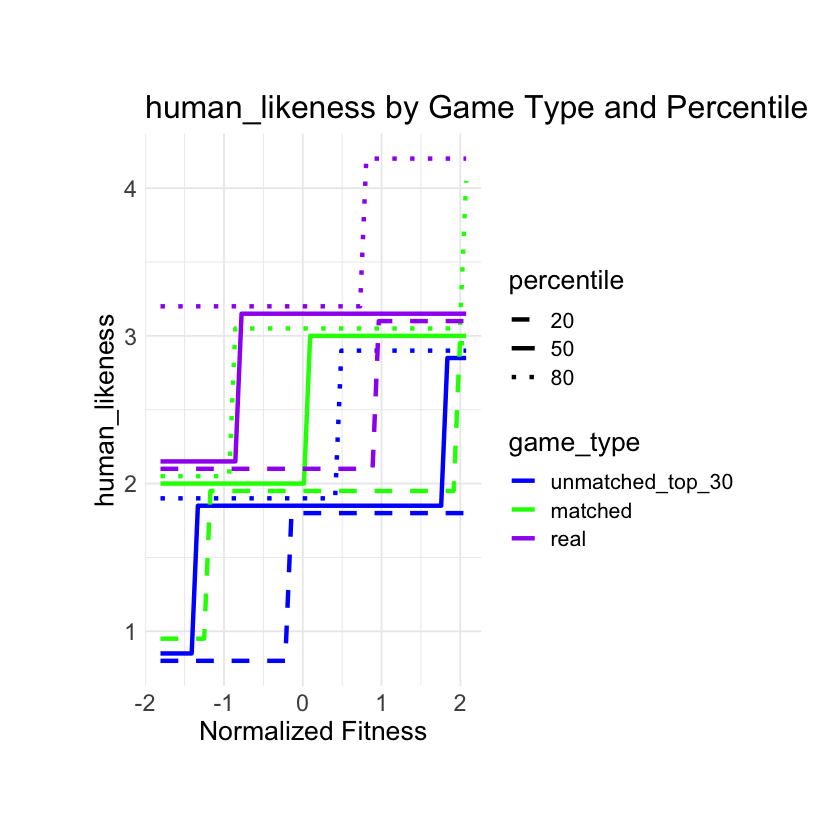

In [ ]:
ggplot(merged_predict_df, aes(x = normalized_fitness, y = bin, color = game_type, linetype = percentile)) +
    geom_line(size = 1.25) +
    labs(x = "Normalized Fitness", y = attr) +
    scale_color_manual(values = c("unmatched" = "red", "unmatched_top_30" = "blue", "matched" = "green", "real" = "purple")) +
    scale_linetype_manual(values = c("20" = "dashed", "50" = "solid", "80" = "dotted")) +
    theme_minimal() +
    theme(
        plot.margin = margin(2, 2, 2, 2, "cm"),
        text = element_text(size = 16),
        axis.text = element_text(size = 14),
    ) + 
    ggtitle(glue("{attr} by Game Type and Percentile"))


In [ ]:
max(merged_predict_df$prediction)

[1] 2.627304

In [ ]:
strictControl <- lmerControl(optCtrl = list(
   algorithm = "NLOPT_LN_NELDERMEAD",
   xtol_abs = 1e-12,
   ftol_abs = 1e-12))

# full_normalized_confident ~ 1 + normalized_fitness + game_type + (1 | participant_id) + (1 | full_game_id), 
l <- lmer(formula = full_normalized_confident ~ 1  + game_type + (1 | full_game_id), 
    data = filtered_df, control = strictControl)

summary(l)

In [ ]:
confident_means = emmeans(confident_model, "game_type")
print(pairs(confident_means, reverse = TRUE))
print(pwpm(confident_means, reverse = TRUE))

In [ ]:
mm <- clmm(C(confident) ~ C(game_type) + normalized_fitness + (1 | participant_id) + (1 | full_game_id),
    # random = d +  , # + (1 | full_game_id), 
    data = filtered_df,
    Hess = TRUE
    )

summary(mm)

In [ ]:
emmeans(mm, "game_type")